# Suspicious suppliers

In [1]:
import pandas as pd
import numpy as np

import re
from unidecode import unidecode

import seaborn as sns

In [2]:
stop_words = [
    r"S\.?A\.? *DE\.? *C\.?V\.?",
    r"S\.? *DE\.? *R\.?L\.? *DE *C\.?V\.?",
    r"S\.?A\.?P\.?I\.? *DE\.? *C\.?V\.?",
    r"S\.?A\.?B\.? *DE\.? *C\.?V\.?",
    r"S\.? *DE\.? *R\.?L\.?",
    r"\bL\.? *T\.? *D\.?\b",
    r"\bS\.? *A\.?\b",
    r"\bR\.? *L\.?\b",
    r"\bC\.? *V\.?\b",
    r"\bS\.? *C\.?\b",
    r"\bS\.? *C\.? *L\.?",
    r"\bS\.?A\.?P\.?I\.?\b",
    r"S\.A\.S\.?"]

In [3]:
def norm(x):
    for word in stop_words:
        x = re.sub(word, "", x)
    x = x.replace(".", "")
    x = x.replace(",", "")
    return unidecode(x.strip().lower())

In [4]:
cnts = pd.read_csv("../data/pre-process/contratos_4.csv", parse_dates=['start_date'])

In [5]:
cnts['year'] = cnts.start_date.dt.year

In [6]:
cnts = cnts.drop('CRI', axis=1)
cnts = cnts.dropna(subset=['usupplier', 'ubuyer'])

In [7]:
cnts['normed'] = cnts['supplier'].apply(norm)

parts = pd.read_json("../data/tables/s3-particulares-sfp.json")
parts['year'] = pd.to_datetime(parts.fechaCaptura).dt.year.astype(int)
parts = parts[['nombreRazonSocial', 'year']]

parts['normed'] = parts['nombreRazonSocial'].apply(norm)

# Federal contracts

In [9]:
cnts_slevel = cnts[cnts.gvmnt_level!='F']

cnts = cnts[cnts.gvmnt_level=='F']

# Sanctioned suppliers

In [10]:
s = set(cnts['normed'].unique()) & set(parts['normed'].unique())

In [11]:
cnts['sanctioned'] = 0

In [12]:
cnts.loc[cnts.normed.isin(s), 'sanctioned'] = 1

# Fake companies

In [13]:
fantasmas = pd.read_csv("../data/tables/fantasmas.csv", delimiter="\n", names=['supplier'])

fantasmas['normed'] = fantasmas['supplier'].apply(norm)

In [14]:
s2 = set(cnts['normed'].unique()) & set(fantasmas['normed'].unique())

In [15]:
cnts.loc[cnts.normed.isin(s2), 'sanctioned'] = 1

# Disapearing suppliers in 2019

In [16]:
supplier_18 = cnts[cnts['year']==2018].groupby('usupplier').size().rename("N").reset_index()

In [17]:
s18 = set(supplier_18[supplier_18.N >= supplier_18.N.mean()]['usupplier'].unique())

In [18]:
s19 = set(cnts[cnts.year==2019]['usupplier'].unique())

In [19]:
cnts['unstable'] = 0
cnts.loc[cnts.usupplier.isin(s18 - s19), 'unstable'] = 1

In [20]:
cnts.columns

Index(['id', 'start_date', 'amount', 'ramo', 'desc_ramo', 'person', 'buyer',
       'file_size', 'single_bid', 'contract_duration', 'prop_window',
       'daily_price', 'contract_type', 'gvmnt_level', 'buyer_state',
       'supplier_country', 'supplier', 'supplier_state', 'state_b', 'code_b',
       'state_s', 'code_s', 'ubuyer', 'usupplier', 'comp', 'long',
       'proportion_window', 'atom', 'buyer_dispersion', 'supplier_dispersion',
       'clustering', 'single_interaction', 'interaction', 's_interaction',
       'year', 'normed', 'sanctioned', 'unstable'],
      dtype='object')

In [21]:
sel_cols = [
    'file_size',
    'amount',
    'person',
    'single_bid',
    'contract_duration',
    'prop_window',
    's_interaction',
    'atom',
    'daily_price',
    'interaction',
    'clustering'
]

## Null model for unstable and sanctioned companies

Let $N$ and $M$ be the number of contracts by sanctioned and unstable companies, respectively. To create a null-model, we will iterate randomly over $N$ and $M$ contracts, respectively to calculate the scores of measures in `sel_cols`.

In [22]:
np.random.seed(42)

In [23]:
N = (cnts.sanctioned == 1).sum()
M = (cnts.unstable == 1).sum()

In [24]:
cnts_ran = cnts[(cnts.unstable==0) & (cnts.sanctioned==0)]

In [25]:
ran_N = []
ran_M = []
for i in range(1000):
    R = np.random.choice(range(cnts_ran.shape[0]), M)
    ran_M.append(list(cnts_ran.iloc[R][sel_cols].mean().values) + [cnts_ran.iloc[R].groupby('usupplier').size().mean()])
    R = np.random.choice(range(cnts_ran.shape[0]), N)
    ran_N.append(list(cnts_ran.iloc[R][sel_cols].mean().values) + [cnts_ran.iloc[R].groupby('usupplier').size().mean()])

In [26]:
df_N = pd.DataFrame(ran_N, columns=list(sel_cols) + ['ncontracts'])
df_M = pd.DataFrame(ran_M, columns=list(sel_cols) + ['ncontracts'])

In [27]:
df_N['null'] = 'sanctioned'
df_M['null'] = 'unstable'

In [28]:
df = pd.concat([df_N, df_M])

## Number of contracts in 2018

In [29]:
df_melt = df.melt(id_vars='null', var_name='column')

In [30]:
cnts[cnts.sanctioned==1][sel_cols].median()

file_size               3.000000
amount               6055.000000
person                  0.000000
single_bid              1.000000
contract_duration      41.000000
prop_window             7.000000
s_interaction           4.114504
atom                    1.000000
daily_price           163.000000
interaction             4.373928
clustering              0.020437
dtype: float64

In [79]:
cnts[cnts.sanctioned==1].groupby('usupplier').size().mean()

37.39457202505219

In [32]:
cnts[cnts.unstable==1][sel_cols].median()

file_size               1.000000
amount               7247.000000
person                  0.000000
single_bid              1.000000
contract_duration      31.000000
prop_window             3.896369
s_interaction           4.500000
atom                    0.000000
daily_price           255.000000
interaction             3.802676
clustering              0.014253
dtype: float64

In [71]:
cnts[cnts.unstable==1][sel_cols].mean()

file_size                10.442371
amount               104730.402328
person                    0.156863
single_bid                0.766991
contract_duration        89.539225
prop_window               5.944184
s_interaction            12.192250
atom                      0.320568
daily_price            3250.662205
interaction              11.620096
clustering                0.015114
dtype: float64

In [80]:
cnts[cnts.unstable==1].groupby('usupplier').size().mean()

28.643237486687966

In [41]:
cnts[cnts.unstable==1].usupplier.nunique()

939

In [69]:
ran = np.random.randint(0, cnts.shape[0], 939)

In [70]:
cnts[(cnts.index.isin(ran)) & (cnts.sanctioned==1)].usupplier.nunique()

15

In [44]:
cnts.usupplier.nunique()

107271

In [42]:
cnts[cnts.sanctioned==1].usupplier.nunique()

479

In [43]:
cnts[(cnts.unstable==1) & (cnts.sanctioned==1)].usupplier.nunique()

22

In [72]:
df.groupby('null').mean()

,file_size,amount,person,single_bid,contract_duration,prop_window,s_interaction,atom,daily_price,interaction,clustering,ncontracts
null,,,,,,,,,,,,
sanctioned,12.130950,160380.757873,0.191850,0.738808,116.894827,6.138937,129.271123,0.303181,2550.232522,25.918241,0.015119,1.793263
unstable,12.177112,158934.972472,0.191845,0.738854,116.844362,6.120360,129.073628,0.303168,2572.103745,25.905466,0.015115,1.987782


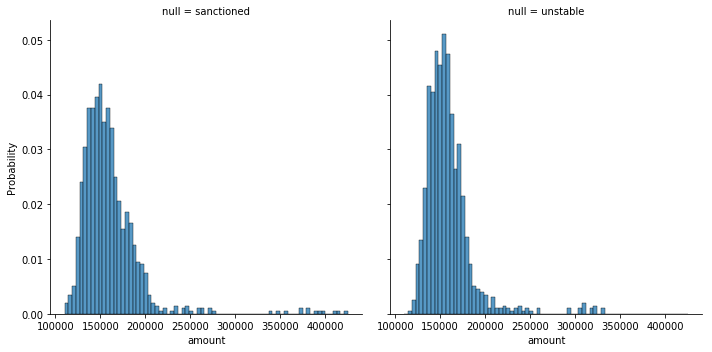

In [37]:
sns.displot(df, x="amount", col="null", stat="probability")